PASO 3 : PREPROCESAMIENTO Y EXPLORACIÓN 
 ========================================

P3.1 Transformación en formato CSV
-----------------------------

Transformación en formato CSV.

El primer paso es realizar la transformación del fichero en formato CSV que permita la interpretación del texto como datos.

Según https://es.ryte.com/wiki/Formato_CSV :

Los datos estructurados se pueden utilizar y procesar con el formato CSV. No hay reglas de codificación fijas para crear archivos CSV. Normalmente, UTF-8 se utiliza y escribe en ASCII de 7 bits. También se utilizan diferentes caracteres (comas, tabulaciones, etc.) para los saltos de línea. Las representaciones comunes son las tablas, en las que también se pueden anidar otras tablas.

La siguiente estructura es típica para un archivo CSV:

Definición de las columnas en la cabecera de la tabla.
Un carácter se utiliza para separar registros individuales.
Un carácter se utiliza para separar columnas individuales (comas, tabulaciones o espacios).
Delimitador de campos Carácter especial HTML dentro del archivo para evitar confusiones con los separadores.

Concretamente los DataSets del USGS están en un formato fácilmente convertible a CSV fácilmente desde su formato  RDB:

https://waterdata.usgs.gov/nwis/?tab_delimited_format_info

Basta con eliminar las líneas de comentarios e interpretar las columnas según los comentarios. Existen mucho software disponible para transformar este tipo de ficheros en formato csv, el utilizado por nosotros es el Asistente de Importación de Microsoft Excel, que previa configuración por defecto, interpreta los datos y los salva en .csv sin mayor problema. 



In [ ]:
import pandas as pd
import math
import numpy as np
import random
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm

path='dataSetTurbidity.csv'


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



Existen métodos para cargar un fichero csv directamente en una serie temporal, pero no se aconseja hacer de esta manera ya que la forma por defecto que tienen implementadas las clases para tratar valores nulos nos ocultan la presencia de éstos, y es posible que se tengan que realizar consideraciones particulares sobre los valores individuales o grupos de valores que sean missing o outliers.


In [ ]:
df_turbidity_source = pd.read_csv(path, delimiter=';')

Chequear que tras el uso de head, el dataframe presenta datos coherentes. Poner especialmente atención en el formato de la columna que contiene el la información de fecha y hora, especialmente en si es el formato local en el que queremos trabajar. Como informaba la cabecera del dataset descargado, la columna 116507_63680 contiene la turbidez.

In [ ]:
df_turbidity_source.head()

,agency_cd,site_no,datetime,tz_cd,116507_63680,116507_63680_cd
0,USGS,11501000,27/05/2019 0:00,PDT,4.7,A
1,USGS,11501000,27/05/2019 0:15,PDT,4.6,A
2,USGS,11501000,27/05/2019 0:30,PDT,4.7,A
3,USGS,11501000,27/05/2019 0:45,PDT,4.9,A
4,USGS,11501000,27/05/2019 1:00,PDT,4.7,A


Vamos a eliminar columnas no necesarias y renombrar aquellas de mayor interes.

Comprobemos que las dimensiones son correctas:


In [ ]:
df_turbidity_source.shape

(66908, 6)

En nuestro caso el dataset está limpio, pero esa no tendría que ser el caso. Trataremos en el siguiente paso cómo tratar con valores missing.

In [ ]:
df_turbidity_source.isnull().sum()

agency_cd          0
site_no            0
datetime           0
tz_cd              0
116507_63680       0
116507_63680_cd    0
dtype: int64

Buscamos valores cero o negativos. Estos valores pueden aparecer como consecuencia de fallos de la instrumentación o valores que no tienen sentido en la unidad que se consideran. Por ejemplo en el caso de la turbidez un valor 0 o un valor negativo indicaría algún tipo de problema en la instrumentación ya que en la práctica ni la turbidez es cero ni puede tener valores negativos. Este tipo de problema depende de la semántica de valor y no sería detectado, a priori como valores missing. Si hubiese tales valores tendrían que ser asignados también como missing. En nuestro caso todo es correcto:


In [ ]:
df_turbidity_source[df_turbidity_source['116507_63680']==0].count()

agency_cd          0
site_no            0
datetime           0
tz_cd              0
116507_63680       0
116507_63680_cd    0
dtype: int64

In [ ]:
df_turbidity_source[df_turbidity_source['116507_63680']<0].count()

agency_cd          0
site_no            0
datetime           0
tz_cd              0
116507_63680       0
116507_63680_cd    0
dtype: int64

In [ ]:
df_turbidity = df_turbidity_source.copy()

P3.2 Tratamiento de Valores Missing
-----------------------------

Generamos artificialmente un dataset **df_turbidity_spoilt** con valores missing  para tratarlo. Quedaría a decisión del analista si el número de missings es muy alto como para no poder usar el dataset.   

In [ ]:
df_turbidity_spoilt= df_turbidity.copy()

In [ ]:

turbidity_array = np.asarray(df_turbidity_spoilt[['116507_63680']])
turbidity_error_prob = 0.0001


for i in range(0,len(turbidity_array)):
 
  #Fallo Tipo 1: Algunos valores NAN Aislados  
  if random.random()<turbidity_error_prob :             
     turbidity_array[i] = np.nan
  
  #Fallo Tipo2: Algunos valores son 0 
  if random.random()<turbidity_error_prob :             
      turbidity_array[i] = 0

  #Fallo Tipo3: Series de valores Nan Seguidos
  if random.random()<turbidity_error_prob : 
    for x in range(0,random.randint(1, 20)):             
      turbidity_array[i+x] = np.nan

  #Fallo Tipo4: Algunos valores son negativos
  if random.random()<turbidity_error_prob :         
      turbidity_array[i] = -(1)*turbidity_array[i]

df_turbidity_spoilt['turbidity_value']= turbidity_array 

print("Missings Detectados : ")
print(df_turbidity_spoilt.isnull().sum())


Missings Detectados : 
agency_cd           0
site_no             0
datetime            0
tz_cd               0
116507_63680        0
116507_63680_cd     0
turbidity_value    58
dtype: int64


Lo primero vamos a asignar a los valores ceros o negativos el valor NaN, ya que respecto a la turbidez, correspondería exactamente la misma naturaleza.

In [ ]:
for x in range(0,len(turbidity_array)):
  if (turbidity_array[x]<=0) :
        turbidity_array[x]= np.nan 

df_turbidity_spoilt['turbidity_value']= turbidity_array 

Comenzamos a deshacernos de los valores missing:
Existen varias técnicas pero tenemos que tener en cuenta que no se pueden eliminar valores en una serie temporal, sino que deben ser imputados de alguna manera valores para no estropear la serie. Existen dos formas: 
* Padding.
* Interpolacion.

Depende del número de valores quiera repararse, de si los missing están seguidos y de la frecuencia de muestreo ambas opciones pueden ser admisibles o no. Si bien, por defecto utilizaremos padding para valores esporádicos e interpolación para el resto de casos. 

In [ ]:
df_turbidity_spoilt['turbidity_value']= df_turbidity_spoilt['turbidity_value'].interpolate(method='polynomial',order=2)

In [ ]:
print("Missings Detectados : ")
print(df_turbidity_spoilt.isnull().sum())

Missings Detectados : 
agency_cd          0
site_no            0
datetime           0
tz_cd              0
116507_63680       0
116507_63680_cd    0
turbidity_value    0
dtype: int64


Mediante la introducción de ruidos y el comparativo con el error cuadrático medio podemos comparar cuáles son los mejores órdenes de interpolación o evaluar otros posibles métodos de interpolación.

In [ ]:
import math
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

y_actual =df_turbidity['116507_63680']
y_predicted =df_turbidity_spoilt['turbidity_value']

rmse = math.sqrt(mean_squared_error(y_actual, y_predicted))
mae =  mean_absolute_error(y_actual, y_predicted)

In [ ]:
print("Error Cuadrático Medio ", rmse)

Error Cuadrático Medio  0.019620259862267637


In [ ]:
print("Media de Errores Absolutos ", mae)

Media de Errores Absolutos  0.0004205845247335814


Ahora utilizamos MAPE:

MAPE = (1/n) * Σ(|actual – prediction| / |actual|) * 100

donde:

* Σ – es sumatorio “sum”
* n – población
* actual –serie real de valores
* prediction – serie de valores predecidos

In [ ]:
#Fuente : https://www.statology.org/mape-python/
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100

In [ ]:
print("MAPE ="+str(mape(y_actual, y_predicted)*100)+"%")

MAPE =3.777582236925324%


P3.3 TRATAMIENTO DE OUTLIERS
============================

Por último nos centraremos en evaluar qué sucede con los valores outliers. Esos valores abnormalmente altos que no podríamos filtrar usando los métodos anteriores. En una serie temporal los outliers pueden imputarse pero no pueden eliminarse. Se tiene que estudiar caso por caso para averiguar su naturaleza. Los correspondientes a anomalías de pequeña duración podrían tratarse con la imputación de datos usando interpolación. En el caso de que sea grande, queda al criterio del analista realizar un reescalado de los datos tomando menos valores para que desaparezcan los outliers o utilizar otro intervalo.


P3.3.1 Z-Score
--------------

Para localizar los outliners  utilizamos la técnica denominada Z-score. Z-score realiza un cálculo sobre la media numérica definiendo un intervalo basado en múltiplos de la desviación típica. En dicho intervalo los valores que son los habitualmente observados y se corresponden a puntaciones de zscore próximas a cero, mientras que las que tienen mayor valor absoluto corresponden (valores más atípicos) con aquellas que son candidatos a outliners.

In [ ]:
data = np.array(df_turbidity['116507_63680'])

In [ ]:
df_turbidity['zscore']=stats.zscore(data)

Trabajando con Z score nos llamará la atención los valores que superen en valor absoluto 1.96xdesv_tipica o 2.58xdesv_tipica (regla tres sigmas), ya que son valores poco probables en una distribución normal, concretamente 5% y 1% respecto al resto (Regla 68-95-99.7).

No se deben eliminar los outliers de forma mecánica, sino que debe estudiarse su causa ya que a menudo el conocimiento del dominio determina si realmente lo son o si representan un evento poco probable pero relevante. 

No obstante como la media no es un estimador robusto: se ve muy afectado por grandes cantidades de outliers.

In [ ]:
thread = 2.58*df_turbidity['116507_63680'].std()

In [ ]:
print("Umbral para Z-score",thread)

Umbral para Z-score 9.347165806434543


In [ ]:
plaussible_outliers = df_turbidity[abs(df_turbidity['116507_63680'])> thread]

Cuando aplicamos los valores a nuestro conjunto inicial vemos que aparecen bastantes sospechosos.

In [ ]:
print("Posibles outliners : " + str(plaussible_outliers.shape[0]))

Posibles outliners : 1296


Vamos a comparar estadísticamente los outliers con el dataset estadístico:

In [ ]:
plaussible_outliers['116507_63680'].describe()


count    1296.000000
mean       21.982176
std        14.002809
min         9.400000
25%        11.400000
50%        17.100000
75%        26.125000
max        66.100000
Name: 116507_63680, dtype: float64

In [ ]:
df_turbidity['116507_63680'].describe()

count    66908.000000
mean         3.131732
std          3.622932
min          0.600000
25%          1.400000
50%          2.500000
75%          3.800000
max         66.100000
Name: 116507_63680, dtype: float64

In [ ]:
#Usamos steps en vez de la fecha porque es más rápido de visualizar.
#Cada step son 15 minutos.
plaussible_outliers.index.name="step"
df_turbidity.index.name="step"

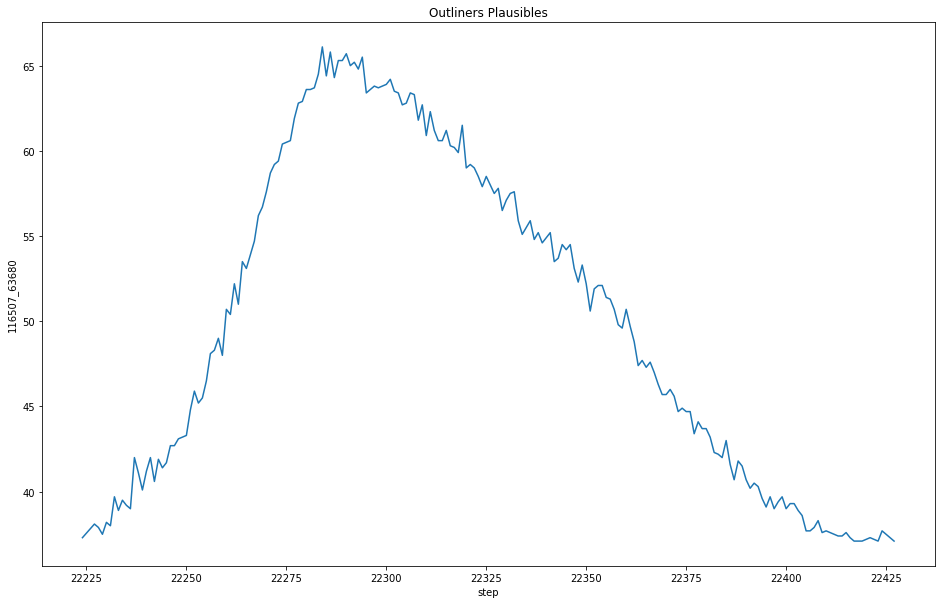

In [ ]:
plt.figure(figsize=(16,10))
sns.lineplot(x=plaussible_outliers.index.name, y="116507_63680", data=plaussible_outliers)
plt.xticks(rotation=0)
plt.title('Outliners Plausibles')
plt.show()

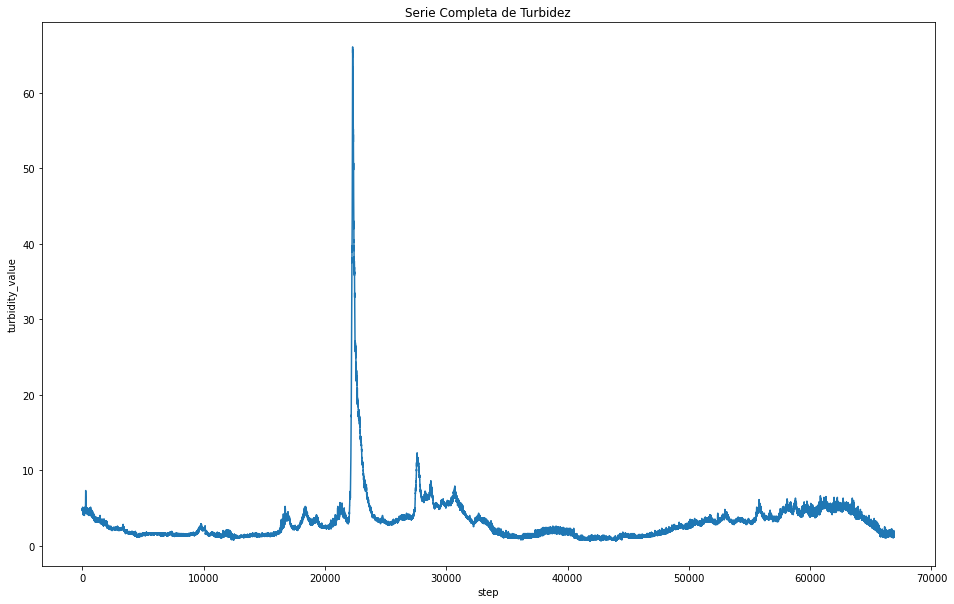

In [ ]:
plt.figure(figsize=(16,10))
sns.lineplot(x=plaussible_outliers.index.name, y="116507_63680", data=df_turbidity)
plt.xticks(rotation=0)
plt.title('Serie Completa de Turbidez')
plt.show()

No es facil identificar outliers, en este caso, puede observarse que los outliers obtenidos son valores válidos, únicamente sucede que corresponde con un suceso no habitual, quizá una inundación, vertido, obra civil junto al cauce, etc. Como cada step corresponde a 15 minutos el evento se prolongó ((22450-22200)/4)/24 = 2.6 días

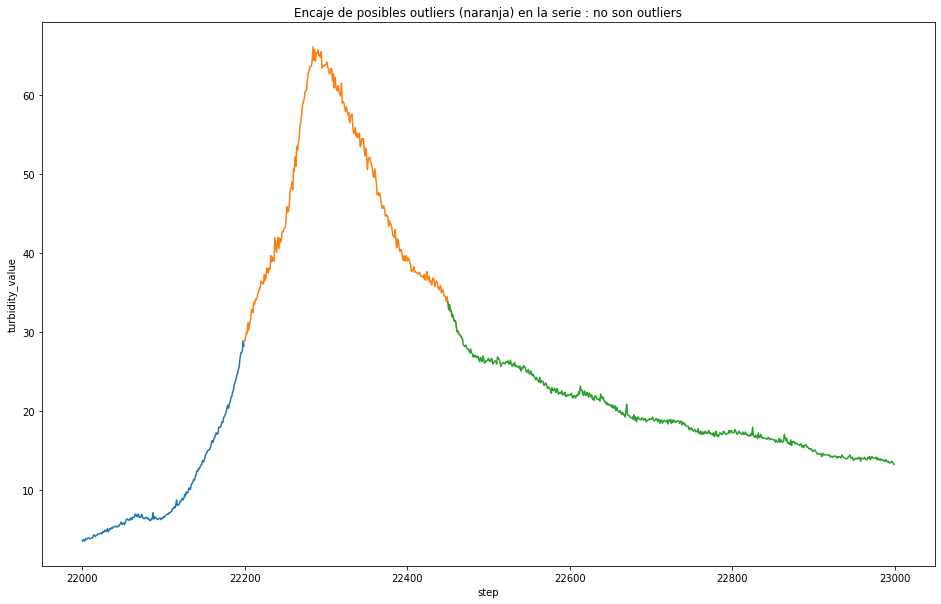

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
plt.figure(figsize=(16,10))
sns.lineplot(x=df_turbidity.index.name, y="116507_63680", data=df_turbidity[22000:22200])
sns.lineplot(x=plaussible_outliers.index.name, y="116507_63680", data=plaussible_outliers)
sns.lineplot(x=df_turbidity.index.name, y="116507_63680", data=df_turbidity[22450:23000])
plt.xticks(rotation=0)
plt.title('Encaje de posibles outliers (naranja) en la serie : no son outliers')
plt.show()


P.3.3.2 Filtro Hample
----------------------



Se ha visto que la técnica de z-score es útil para identificar posibles outliers. También se ha comentado que no debemos sustituir los outliers en las series temporares sin analizar su naturaleza, ya que como hemos visto en el apartado anterior, ya que puntos alejados no son auténticamente outliers. Uno de los problemas de z score es que está basado en la media, y por tanto no es un estimador robusto (es decir que la presencia de outliers le afecta significativamente). Existe una técnica adicional que además permite realizar la imputación de valores. Se denomina filtro Hample y está disponible como paquete en https://pypi.org/project/hampel/.  

In [ ]:
pip install hampel

Outliers Totales: 6458


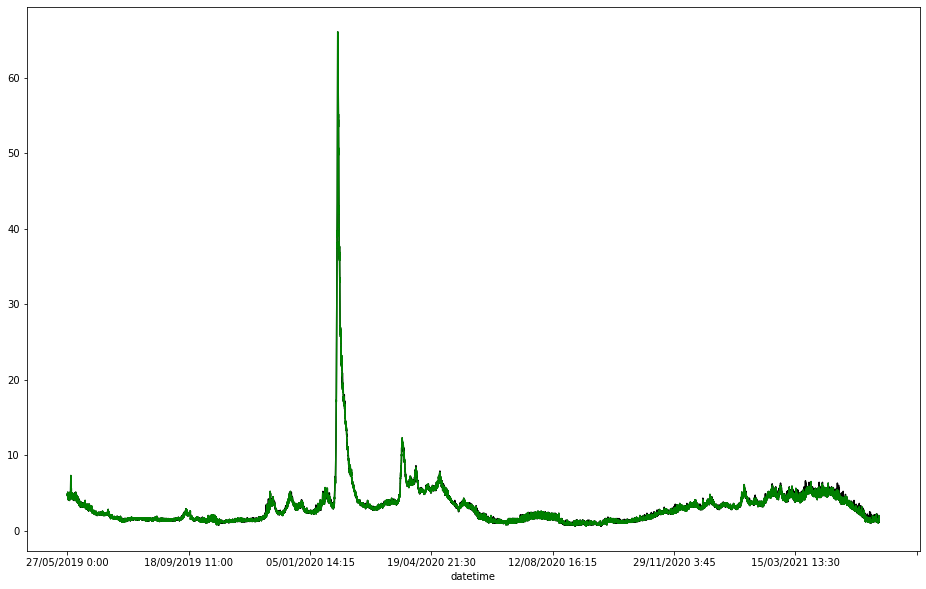

In [ ]:
#Fuente : https://pypi.org/project/hampel/

from hampel import hampel
import matplotlib.pyplot as plt
import pandas as pd
from hampel import hampel

df_turbidity_hample_test = pd.read_csv(path, delimiter=';', index_col='datetime')
ts = df_turbidity_hample_test['116507_63680'].squeeze()

outlier_indices = hampel(ts, window_size=150, n=3)
#print("Índices: ", outlier_indices)
print("Outliers Totales:",len(outlier_indices))

ts_imputation = hampel(ts, window_size=5, n=3, imputation=True)
plt.figure(figsize=(16,10))
ts.plot(style="k-")
ts_imputation.plot(style="g-")
plt.show()

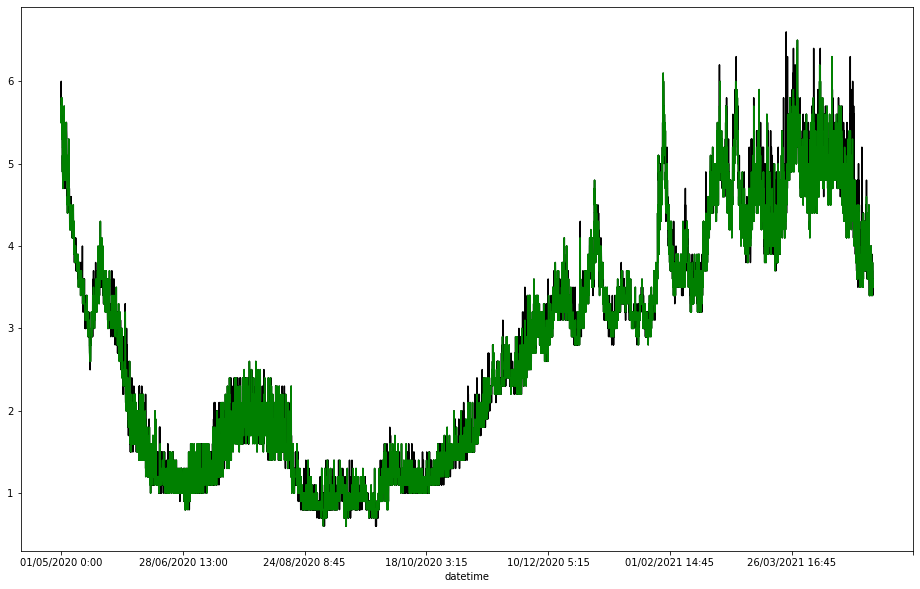

In [ ]:
plt.figure(figsize=(16,10))
ts.loc['01/05/2020 0:00':'01/05/2021 0:00'].plot(style="k-")
ts_imputation.loc['01/05/2020 0:00':'01/05/2021 0:00'].plot(style="g-")
plt.show()

P3.4 EXPLORACIÓN INICIAL
========================

In [ ]:
df_turbidity_source = pd.read_csv(path, delimiter=';', index_col='datetime')

In [ ]:
series_turbidity = df_turbidity_source['116507_63680'].squeeze()

In [ ]:
series_turbidity

datetime
27/05/2019 0:00     4.7
27/05/2019 0:15     4.6
27/05/2019 0:30     4.7
27/05/2019 0:45     4.9
27/05/2019 1:00     4.7
                   ... 
27/05/2021 10:30    1.1
27/05/2021 10:45    1.2
27/05/2021 11:00    1.2
27/05/2021 11:15    1.2
27/05/2021 11:30    1.3
Name: 116507_63680, Length: 66908, dtype: float64

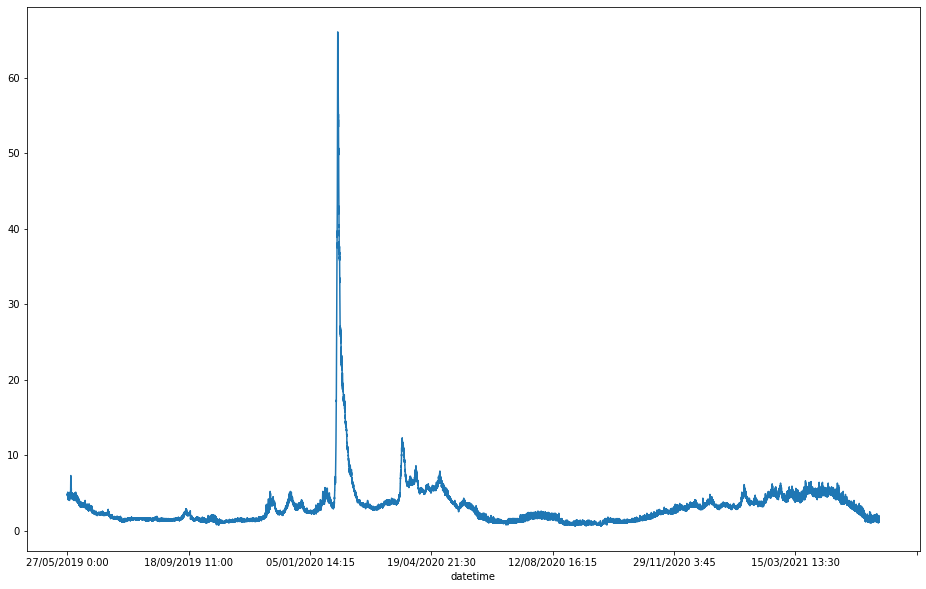

In [ ]:
plt.figure(figsize=(16,10))
series_turbidity.name="turbidity_value"
series_turbidity.plot()

A partir de ahora trabajaremos sólo con los datos del último año, por ser más recientes y representativos al eliminar picos no vistos en la serie temporal larga de turbidez.

In [ ]:
series_turbidity.describe()

count    66908.000000
mean         3.131732
std          3.622932
min          0.600000
25%          1.400000
50%          2.500000
75%          3.800000
max         66.100000
Name: turbidity_value, dtype: float64

In [ ]:
series_turbidity.loc['01/05/2020 0:00':'01/05/2021 0:00'].describe()

count    33340.000000
mean         2.685471
std          1.421787
min          0.600000
25%          1.300000
50%          2.700000
75%          3.800000
max          6.600000
Name: turbidity_value, dtype: float64

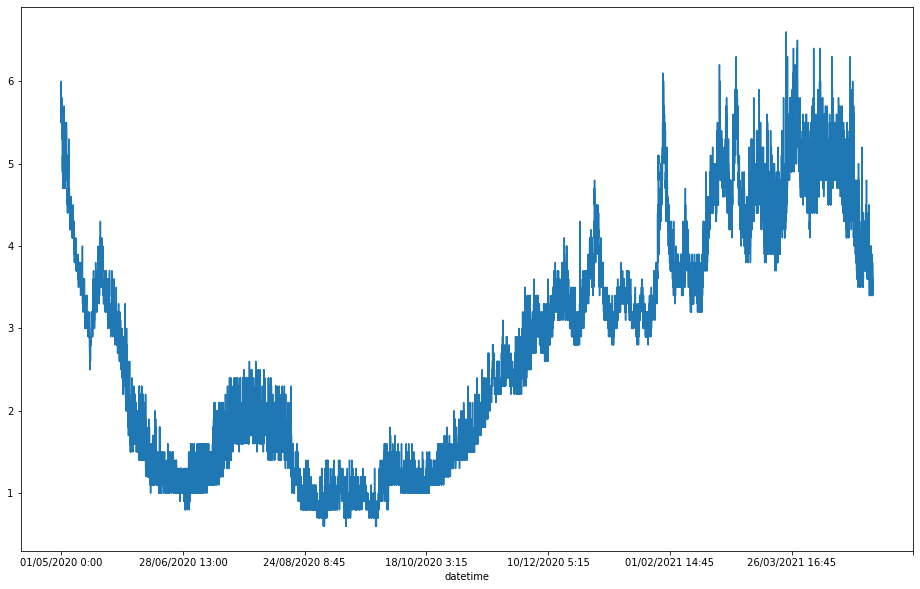

In [ ]:
plt.figure(figsize=(16,10))
series_turbidity.loc['01/05/2020 0:00':'01/05/2021 0:00'].plot()

Está claro que la turbidez no sigue una distribución normal: 

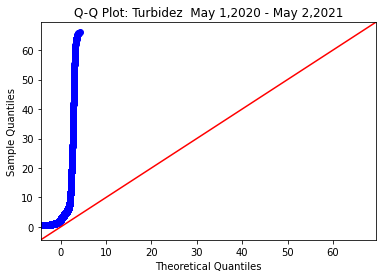

In [ ]:
fig = sm.qqplot(series_turbidity, line='45')
plt.title("Q-Q Plot: Turbidez  May 1,2020 - May 2,2021")
plt.show()

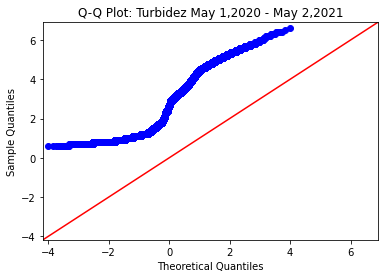

In [ ]:
fig = sm.qqplot(series_turbidity.loc['01/05/2020 0:00':'01/05/2021 0:00'], line='45')
plt.title("Q-Q Plot: Turbidez May 1,2020 - May 2,2021")
plt.show()

No es exponencial

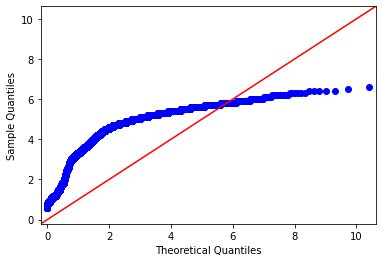

In [ ]:
fig = sm.qqplot(series_turbidity.loc['01/05/2020 0:00':'01/05/2021 0:00'], line='45',dist='expon')
plt.show()

No es logistica

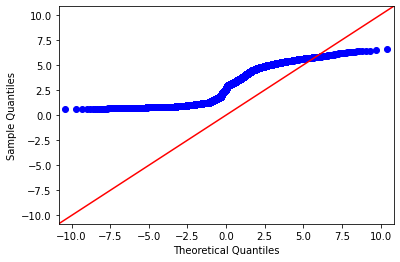

In [ ]:
fig = sm.qqplot(series_turbidity.loc['01/05/2020 0:00':'01/05/2021 0:00'], line='45',dist='logistic')
plt.show()

Solo nos queda hacer el estudio más simple posible: Histogramas + Box Plot

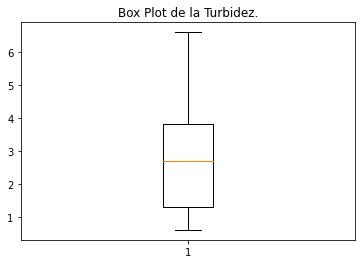

In [ ]:
plt.title("Box Plot de la Turbidez.")
plt.boxplot(series_turbidity.loc['01/05/2020 0:00':'01/05/2021 0:00'])
   
plt.show() 

Afortunadamente np.histogram_bin_edges nos libra de tener que tratar con el problema de elegir correctamente los bins del histograma respecto a la población

In [ ]:
bins_considered = np.histogram_bin_edges(series_turbidity.loc['01/05/2020 0:00':'01/05/2021 0:00']).shape[0]

Aquí obtenemos los intervalos de los bins.

In [ ]:
np.histogram_bin_edges(series_turbidity.loc['01/05/2020 0:00':'01/05/2021 0:00'])

array([0.6, 1.2, 1.8, 2.4, 3. , 3.6, 4.2, 4.8, 5.4, 6. , 6.6])

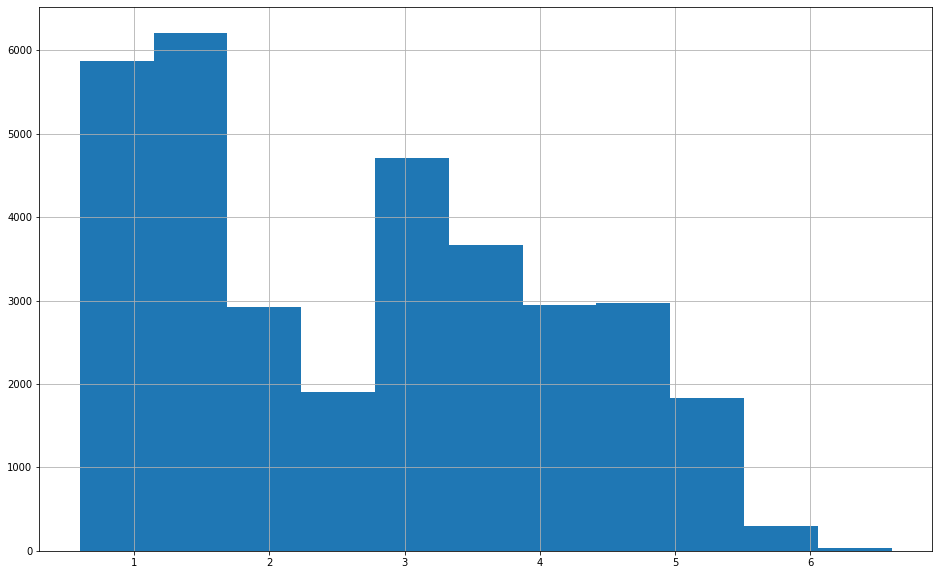

In [ ]:
plt.figure(figsize=(16,10))
series_turbidity.loc['01/05/2020 0:00':'01/05/2021 0:00'].hist(bins=bins_considered)

También es muy util los deciles:

In [ ]:
np.percentile(series_turbidity.loc['01/05/2020 0:00':'01/05/2021 0:00'], np.arange(0, 100, 10)) # deciles

array([0.6, 1. , 1.2, 1.5, 1.8, 2.7, 3.2, 3.6, 4.1, 4.7])

In [ ]:
Un refresco para leer los box plot. Fuente : https://www.statology.org/:

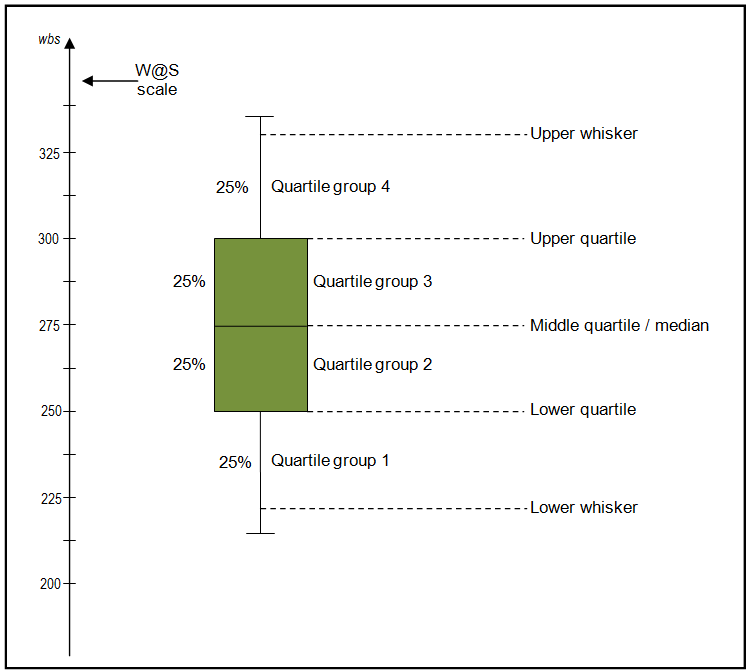

La hipótesis nula de la prueba KS (prueba de Kolmogorov-Smirnov) es que las distribuciones son iguales. Por lo tanto, cuanto menor sea el valor p, mayor será la evidencia estadística para rechazar la hipótesis nula y concluir que las distribuciones son diferentes. La prueba sólo le permite hablar de su confianza en que las distribuciones son diferentes, no iguales, ya que la prueba está diseñada para encontrar alfa, la probabilidad de error de tipo I.
 
 https://stackoverflow.com/questions/37559470/what-do-all-the-distributions-available-in-scipy-stats-look-like

https://docs.scipy.org/doc/scipy/reference/stats.html

In [ ]:
list_of_dists = ['alpha','anglit','arcsine','beta','betaprime','bradford','burr','burr12','cauchy','chi','chi2','cosine','dgamma','dweibull','erlang','expon','exponnorm','exponweib','exponpow','f','fatiguelife','fisk','foldcauchy','foldnorm','frechet_r','frechet_l','genlogistic','genpareto','gennorm','genexpon','genextreme','gausshyper','gamma','gengamma','genhalflogistic','gilbrat','gompertz','gumbel_r','gumbel_l','halfcauchy','halflogistic','halfnorm','halfgennorm','hypsecant','invgamma','invgauss','invweibull','johnsonsb','johnsonsu','kstwobign','laplace','levy','levy_l','logistic','loggamma','loglaplace','lognorm','lomax','maxwell','mielke','nakagami','ncx2','ncf','nct','norm','pareto','pearson3','powerlaw','powerlognorm','powernorm','rdist','reciprocal','rayleigh','rice','recipinvgauss','semicircular','t','triang','truncexpon','truncnorm','tukeylambda','uniform','vonmises','vonmises_line','wald','weibull_min','weibull_max']
print("Distribuciones testeadas : ",len(list_of_dists))

Distribuciones testeadas :  87


In [ ]:
# Fuente : https://www.statology.org/kolmogorov-smirnov-test-python/

list_of_dists = ['alpha','anglit','arcsine','beta','betaprime','bradford','burr','burr12','cauchy','chi','chi2','cosine','dgamma','dweibull','erlang','expon','exponnorm','exponweib','exponpow','f','fatiguelife','fisk','foldcauchy','foldnorm','frechet_r','frechet_l','genlogistic','genpareto','gennorm','genexpon','genextreme','gausshyper','gamma','gengamma','genhalflogistic','gilbrat','gompertz','gumbel_r','gumbel_l','halfcauchy','halflogistic','halfnorm','halfgennorm','hypsecant','invgamma','invgauss','invweibull','johnsonsb','johnsonsu','kstwobign','laplace','levy','levy_l','logistic','loggamma','loglaplace','lognorm','lomax','maxwell','mielke','nakagami','ncx2','ncf','nct','norm','pareto','pearson3','powerlaw','powerlognorm','powernorm','rdist','reciprocal','rayleigh','rice','recipinvgauss','semicircular','t','triang','truncexpon','truncnorm','tukeylambda','uniform','vonmises','vonmises_line','wald','weibull_min','weibull_max']


results = []
for i in list_of_dists:
    dist = getattr(stats, i)
    param = dist.fit(series_turbidity.loc['01/05/2020 0:00':'01/05/2021 0:00'])
    a = stats.kstest(series_turbidity.loc['01/05/2020 0:00':'01/05/2021 0:00'], i, args=param)
    results.append((i,a[0],a[1]))
    
    
results.sort(key=lambda x:float(x[2]), reverse=True)
for j in results:
    print("{}: statistic={}, pvalue={}".format(j[0], j[1], j[2]))

Al final no se ajusta a ninguna distribución: (p<0.05=> Se rechaza que sea la misma distribución):

mielke: statistic=0.07284251903060984, pvalue=4.4149616701083784e-154
dweibull: statistic=0.08715845888500169, pvalue=2.0560417749565516e-220
powerlognorm: statistic=0.10093955988896997, pvalue=1.762821490800972e-295
triang: statistic=0.101410555925189, pvalue=3.063812363752865e-298
burr: statistic=0.10458573535568744, pvalue=3.5079906e-317
dgamma: statistic=0.10467992240401407, pvalue=9.424925e-318
genpareto: statistic=0.10487396700091445, pvalue=6.2623e-319
johnsonsb: statistic=0.10520615320804072, pvalue=5.97e-321
alpha: statistic=0.12309114485005634, pvalue=0.0
anglit: statistic=0.18522310553027746, pvalue=0.0
arcsine: statistic=0.27869545800024154, pvalue=0.0
beta: statistic=0.12226569564878936, pvalue=0.0
betaprime: statistic=0.1383091160914094, pvalue=0.0
bradford: statistic=0.1668565323546263, pvalue=0.0
burr12: statistic=0.12224495206390762, pvalue=0.0
cauchy: statistic=0.18178170133313604, pvalue=0.0
chi: statistic=0.12231675404077985, pvalue=0.0
chi2: statistic=0.116062074533819, pvalue=0.0
cosine: statistic=0.16180533044978596, pvalue=0.0
erlang: statistic=0.13665071247785443, pvalue=0.0
expon: statistic=0.15047588312145832, pvalue=0.0
exponnorm: statistic=0.14433445855821792, pvalue=0.0
exponweib: statistic=0.13707004663192357, pvalue=0.0
exponpow: statistic=0.13372168299128845, pvalue=0.0
f: statistic=0.13671570388558985, pvalue=0.0
fatiguelife: statistic=0.14381898751477773, pvalue=0.0
fisk: statistic=0.12935113238693374, pvalue=0.0
foldcauchy: statistic=0.17428180306029561, pvalue=0.0
foldnorm: statistic=0.11546413635253011, pvalue=0.0
frechet_r: statistic=0.1232422319901976, pvalue=0.0
frechet_l: statistic=0.12505574985406887, pvalue=0.0
genlogistic: statistic=0.11824512536738396, pvalue=0.0
gennorm: statistic=0.17642616164093933, pvalue=0.0
genexpon: statistic=0.11954260420392518, pvalue=0.0
genextreme: statistic=0.12506262224423342, pvalue=0.0
gausshyper: statistic=0.12279843130605606, pvalue=0.0
gamma: statistic=0.13665444469630184, pvalue=0.0
gengamma: statistic=0.1376817784149409, pvalue=0.0
genhalflogistic: statistic=0.14310334260072738, pvalue=0.0
gilbrat: statistic=0.181373835440795, pvalue=0.0
gompertz: statistic=0.11467075754243988, pvalue=0.0
gumbel_r: statistic=0.11867000368925262, pvalue=0.0
gumbel_l: statistic=0.1448415599448652, pvalue=0.0
halfcauchy: statistic=0.19444859922218538, pvalue=0.0
halflogistic: statistic=0.2075566021414335, pvalue=0.0
halfnorm: statistic=0.20187744415666714, pvalue=0.0
halfgennorm: statistic=0.14970715900445877, pvalue=0.0
hypsecant: statistic=0.12879775892019274, pvalue=0.0
invgamma: statistic=0.13115024252243268, pvalue=0.0
invgauss: statistic=0.14905944477646504, pvalue=0.0
invweibull: statistic=0.12149734552277897, pvalue=0.0
johnsonsu: statistic=0.1490746607069494, pvalue=0.0
kstwobign: statistic=0.11761541149539181, pvalue=0.0
laplace: statistic=0.1666819850287099, pvalue=0.0
levy: statistic=0.33334958311431073, pvalue=0.0
levy_l: statistic=0.5380055062891604, pvalue=0.0
logistic: statistic=0.1334448078461164, pvalue=0.0
loggamma: statistic=0.14269593302705508, pvalue=0.0
loglaplace: statistic=0.16260031888702564, pvalue=0.0
lognorm: statistic=0.1424027528886178, pvalue=0.0
lomax: statistic=0.15307267478621545, pvalue=0.0
maxwell: statistic=0.14392540653999253, pvalue=0.0
nakagami: statistic=0.10815605724449673, pvalue=0.0
ncx2: statistic=0.11344606067587748, pvalue=0.0
ncf: statistic=0.13208782165605593, pvalue=0.0
nct: statistic=0.14474047804331241, pvalue=0.0
norm: statistic=0.14525850033979743, pvalue=0.0
pareto: statistic=0.1899845653559697, pvalue=0.0
pearson3: statistic=0.13664123456001298, pvalue=0.0
powerlaw: statistic=0.1811636436845253, pvalue=0.0
powernorm: statistic=1.0, pvalue=0.0
rdist: statistic=0.2249434772392929, pvalue=0.0
reciprocal: statistic=0.8842231553689263, pvalue=0.0
rayleigh: statistic=0.1472690511039812, pvalue=0.0
rice: statistic=0.14795082231586426, pvalue=0.0
recipinvgauss: statistic=0.13908332370858012, pvalue=0.0
semicircular: statistic=0.21980149571921198, pvalue=0.0
t: statistic=0.14526921427759348, pvalue=0.0
truncexpon: statistic=0.17554642830685496, pvalue=0.0
truncnorm: statistic=0.9265146970605879, pvalue=0.0
tukeylambda: statistic=0.23429676917776016, pvalue=0.0
uniform: statistic=0.22470505898820237, pvalue=0.0
vonmises: statistic=2.9264499201579094e+27, pvalue=0.0
vonmises_line: statistic=0.12553300029071934, pvalue=0.0
wald: statistic=0.16067585588792188, pvalue=0.0
weibull_min: statistic=0.1232422319901976, pvalue=0.0
weibull_max: statistic=0.12505574985406887, pvalue=0.0


**Se puede decir oficialmente que la turbidez no se ajusta a ninguna    distribución del paquete de python**. A continuación realicemos la primera exploración usando la librería de Facebook Prophet.

In [ ]:
!pip install prophet

     |████████████████████████████████| 71kB 5.1MB/s 
     |████████████████████████████████| 51kB 6.3MB/s 
     |████████████████████████████████| 184kB 16.6MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-cp37-none-any.whl size=6638497 sha256=32c072b2604e9809054efa8ccc391cfd64a005848b6f8038904e3b45160c66c0
  Stored in directory: /root/.cache/pip/wheels/92/1d/02/bc0a91bd3a84e060722075d2b0b68e875e37ec7dc49451d513
Successfully built prophet
ERROR: fbprophet 0.7.1 has requirement cmdstanpy==0.9.5, but you'll have cmdstanpy 0.9.68 which is incompatible.
  Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5


In [ ]:
from fbprophet import Prophet

In [ ]:
df_turbidity_prophet = pd.read_csv(path, delimiter=';')

In [ ]:
del df_turbidity_prophet['agency_cd']
del df_turbidity_prophet['site_no']
del df_turbidity_prophet['tz_cd']
del df_turbidity_prophet['116507_63680_cd']
df_turbidity_prophet.columns = ['ds','y']

Prophet necesita adaptar los datos de una manera determinada para funcionar. En el campo ds del dataframe obligatoriamente el componente de índice temporal de la serie. En el campo y, los valores, en este caso de la turbidez: 
*  ds: datetime
*  y: turbidez

In [ ]:
df_turbidity_prophet.columns = ['ds','y']

In [ ]:
df_turbidity_prophet['ds']=pd.to_datetime(df_turbidity_prophet['ds'])

In [ ]:
m=Prophet()
m.fit(df_turbidity_prophet)

INFO:numexpr.utils:NumExpr defaulting to 2 threads.


Prophet trabaja con periodos de un día, haremos una predicción semanal sobre la última fecha:

In [ ]:
future = m.make_future_dataframe(periods=7,freq='15min')

In [ ]:
forecast=m.predict(future)

In [ ]:
forecast.columns

Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'daily', 'daily_lower', 'daily_upper', 'multiplicative_terms',
       'multiplicative_terms_lower', 'multiplicative_terms_upper', 'weekly',
       'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
       'yearly_upper', 'additive_terms', 'additive_terms_lower',
       'additive_terms_upper', 'yhat'],
      dtype='object')

Se puede consultar en los puntos en el dataset forcast individuales:

In [ ]:
forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2019-01-06 00:00:00,2.704144,-2.755430,4.932429,2.704144,2.704144,-0.007394,-0.007394,-0.007394,-0.591463,-0.591463,-0.591463,-0.115743,-0.115743,-0.115743,-0.468325,-0.468325,-0.468325,0.0,0.0,0.0,1.104744
1,2019-01-06 00:15:00,2.703973,-2.803829,4.925855,2.703973,2.703973,-0.009539,-0.009539,-0.009539,-0.593880,-0.593880,-0.593880,-0.114742,-0.114742,-0.114742,-0.469599,-0.469599,-0.469599,0.0,0.0,0.0,1.098137
2,2019-01-06 00:30:00,2.703803,-2.591907,4.689404,2.703803,2.703803,-0.011481,-0.011481,-0.011481,-0.596095,-0.596095,-0.596095,-0.113742,-0.113742,-0.113742,-0.470872,-0.470872,-0.470872,0.0,0.0,0.0,1.092080
3,2019-01-06 00:45:00,2.703632,-2.547196,4.662593,2.703632,2.703632,-0.013151,-0.013151,-0.013151,-0.598037,-0.598037,-0.598037,-0.112742,-0.112742,-0.112742,-0.472143,-0.472143,-0.472143,0.0,0.0,0.0,1.086759
4,2019-01-06 01:00:00,2.703462,-2.508560,4.778221,2.703462,2.703462,-0.014489,-0.014489,-0.014489,-0.599647,-0.599647,-0.599647,-0.111745,-0.111745,-0.111745,-0.473414,-0.473414,-0.473414,0.0,0.0,0.0,1.082338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
66903,2021-12-06 00:30:00,3.438410,0.612385,7.762322,3.438410,3.438410,-0.011481,-0.011481,-0.011481,0.210998,0.210998,0.210998,-0.098717,-0.098717,-0.098717,0.321196,0.321196,0.321196,0.0,0.0,0.0,4.163909
66904,2021-12-06 00:45:00,3.438420,0.479242,7.819760,3.438420,3.438420,-0.013151,-0.013151,-0.013151,0.209371,0.209371,0.209371,-0.099654,-0.099654,-0.099654,0.322177,0.322177,0.322177,0.0,0.0,0.0,4.158324
66905,2021-12-06 01:00:00,3.438429,0.623468,7.911521,3.438429,3.438429,-0.014489,-0.014489,-0.014489,0.208063,0.208063,0.208063,-0.100605,-0.100605,-0.100605,0.323158,0.323158,0.323158,0.0,0.0,0.0,4.153840
66906,2021-12-06 01:15:00,3.438438,0.696666,7.825117,3.438438,3.438438,-0.015442,-0.015442,-0.015442,0.207128,0.207128,0.207128,-0.101570,-0.101570,-0.101570,0.324139,0.324139,0.324139,0.0,0.0,0.0,4.150635


* Puntos negros fuera de la zona azul: son los puntos no explicados por el modelo.
* Zona azúl sombreada : intervalo de confianza 80% sobre la tendencia.


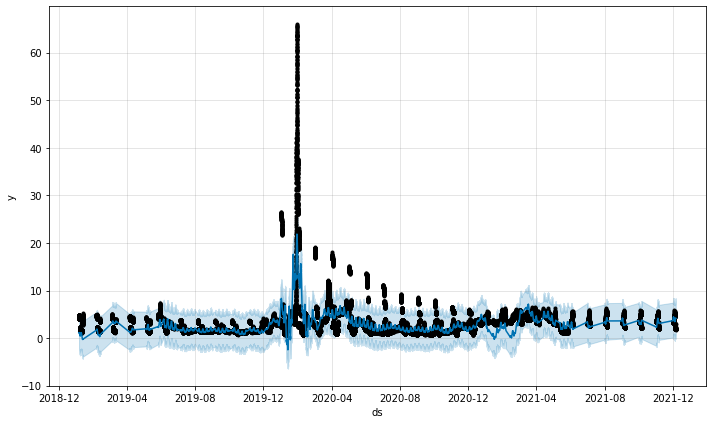

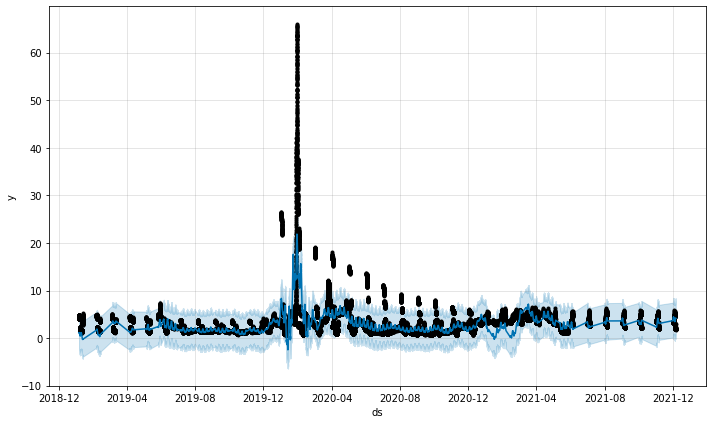

In [ ]:
m.plot(forecast)

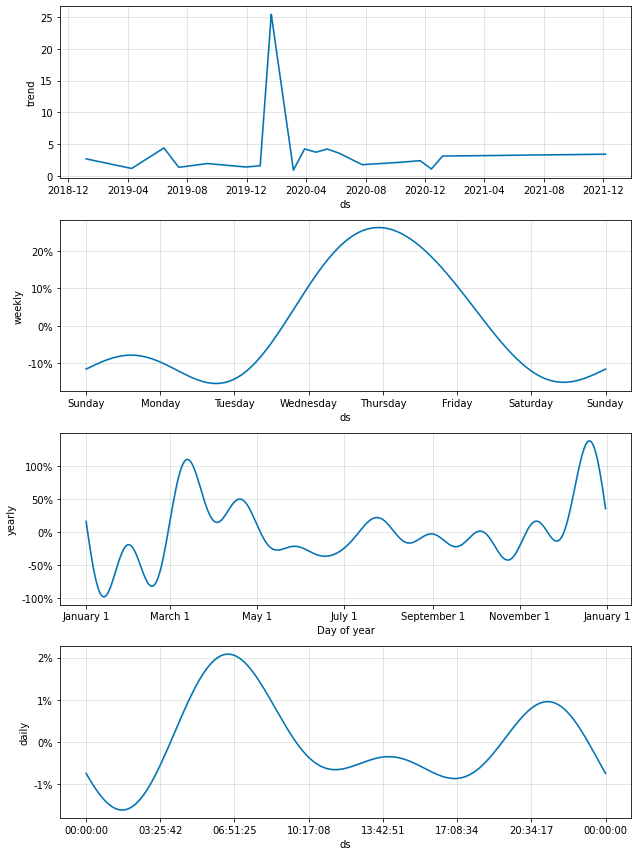

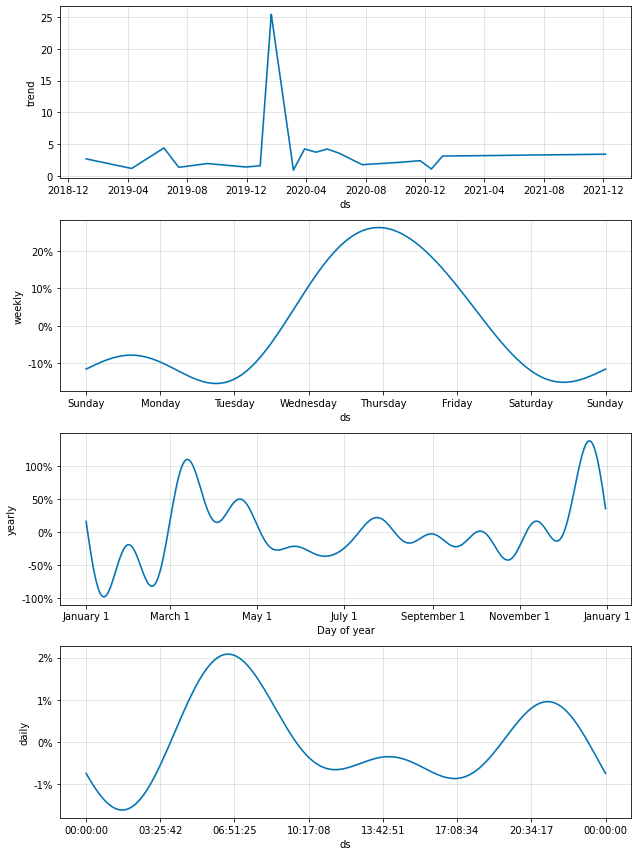

In [ ]:
m.plot_components(forecast)